# Descripción del proyecto
Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. (Sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios y las usuarias participan en experimentos.

## Paso 1. Importación de librerías y carga de dataset.

In [1]:
# Importar librerías

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from scipy import stats as st
from scipy.stats import ttest_ind

In [43]:
# Cargar dataset

data = pd.read_csv('/datasets/logs_exp_us.csv', delimiter='\t')

## Paso 2. Preparar los datos para el análisis

* Cambia el nombre de las columnas de manera que sea conveniente para ti.
* Comprueba si hay tipos de datos y valores ausentes. Corrige los datos si es necesario.
* Agrega una columna de fecha y hora y una columna separada para las fechas.

In [3]:
# Dataset data 

data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# Información de data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Cambia el nombre de las columnas de manera que sea conveniente para ti

In [5]:
# Renombrar las columnas

data.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

### Comprueba si hay tipos de datos y valores ausentes o duplicados. Corrige los datos si es necesario

In [6]:
# Verificar los valores ausentes

missing_values = data.isnull().sum()
data_types = data.dtypes

missing_values, data_types.head()

(event_name         0
 device_id_hash     0
 event_timestamp    0
 exp_id             0
 dtype: int64,
 event_name         object
 device_id_hash      int64
 event_timestamp     int64
 exp_id              int64
 dtype: object)

In [7]:
# Verificar duplicados

data.duplicated().sum()

413

In [8]:
# Quitar los duplicados

data = data.drop_duplicates().reset_index()

data.duplicated().sum()

0

### Agrega una columna de fecha y hora y una columna separada para las fechas

In [9]:
# Convertir 'event_timestamp' a formato datetime

data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')

In [10]:
# Crear una columna para la fecha

data['event_date'] = data['event_datetime'].dt.date

display(data.head(), data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            243713 non-null  int64         
 1   event_name       243713 non-null  object        
 2   device_id_hash   243713 non-null  int64         
 3   event_timestamp  243713 non-null  int64         
 4   exp_id           243713 non-null  int64         
 5   event_datetime   243713 non-null  datetime64[ns]
 6   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 13.0+ MB


,index,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


None

* Se renombraron las columnas usando la metodología snake_case y no se hallaron valores ausentes.
* Se realizó el cambio del tipo de datos de 'event_timestamp' a datetime en segundos.
* Se encontraron 413 duplicados y se procedieron a eliminar.
* Se crearon las 2 nuevas columnas.

## Paso 3. Paso 3. Estudiar y comprobar los datos

* ¿Cuántos eventos hay en los registros?
* ¿Cuántos usuarios y usuarias hay en los registros?
* ¿Cuál es el promedio de eventos por usuario?
* ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?
* ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
* Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

### ¿Cuántos eventos hay en los registros?

In [11]:
# Contar el numero de eventos

total_events = data['event_name'].count()
total_events

243713

### ¿Cuántos usuarios y usuarias hay en los registros?

In [12]:
# Contar el número de usuarios únicos

total_users = data['device_id_hash'].nunique()
total_users

7551

### ¿Cuál es el promedio de eventos por usuario?

In [13]:
# Calcular el número de eventos promedio por usuario

average_events_per_user = total_events / total_users
average_events_per_user

32.27559263673685

### ¿Qué periodo de tiempo cubren los datos?

In [14]:
# Encontrar las fechas mínimas y máximas del dataset

min_date = data['event_date'].min()
max_date = data['event_date'].max()

print(min_date, max_date)

2019-07-25 2019-08-07


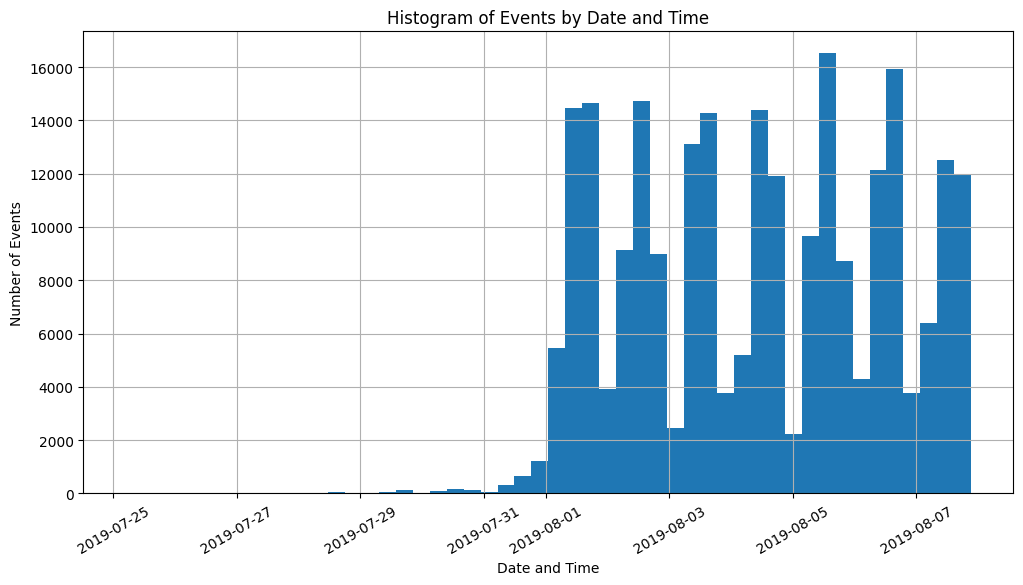

In [15]:
# Plot a histogram of events by date and time

plt.figure(figsize=(12, 6))
data['event_datetime'].hist(bins=50)
plt.title('Histogram of Events by Date and Time')
plt.xlabel('Date and Time')
plt.ylabel('Number of Events')
plt.xticks(rotation = 30)
plt.grid(True)
plt.show()

* Se observa la concentración de eventos en ciertos periodos, esto podría indicar que los datos no son igualmente completos en todo el periodo cubierto.
* Se debería identificar cualquier fecha o rango de tiempo donde los eventos están significativamente menos representados para evaluar si esos datos deberían ser excluidos.

In [16]:
# Analizaremos la distribución de eventos en el timepo para determinar cuando los datos se tornan consistentes
# Agrupar la data por fechas y contar los eventos por día

events_per_day = data.groupby('event_date').size()

events_per_day

event_date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
dtype: int64

In [17]:
# Identificar cuando los datos se vuelven consistentes

consistent_start_date = events_per_day.idxmax()

consistent_start_date

datetime.date(2019, 8, 1)

In [18]:
# Filtrar los datos para incluir sólo los eventos después del 01.08.2019

filtered_data = data[data['event_date'] >= consistent_start_date]

* El análisis sugiere que los datos comienzan a ser consistentes a partir del 1 de agosto de 2019.
* Por lo tanto se filtró el dataset para utilizar la parte mas signficativa del dataset.

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [19]:
# Calcular el numero de eventos y usuarios perdios al excluir los datos antiguos

events_lost = total_events - filtered_data['event_name'].count()
users_lost = total_users - filtered_data['device_id_hash'].nunique()

events_lost_percent = (events_lost / total_events) * 100

display(events_lost, users_lost, events_lost_percent)

2826

17

1.159560630741897

* Al excluir los datos anteriores al 1 de agosto de 2019, se pierden 2,826 eventos. Lo que representa solamente el 1.16% del total de eventos.
* Se pierden 17 usuarios al excluir los datos anteriores a esta fecha.

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>

Agregada respuesta.
</div>

### Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [20]:
# Verificar la representación de los tres grupos experimentales en los datos filtrados

groups_in_filtered_data = filtered_data['exp_id'].nunique()

groups_in_filtered_data

3

* A pesar de la exclusión, los tres grupos experimentales (246, 247 y 248) siguen estando representados en los datos filtrados.

## Paso 4. Estudiar el embudo de eventos

* Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
* Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias  Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.
* ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
* Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).
* ¿En qué etapa pierdes más usuarios y usuarias?
* ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

### Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [21]:
# Contar la frecuencia de cada evento y ordenar por mayor frecuencia

event_frequencies = filtered_data['event_name'].value_counts()

event_frequencies

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

### Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [22]:
# Contar el número de usuarios únicos por evento

unique_users_per_event = filtered_data.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)
unique_users_per_event

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id_hash, dtype: int64

In [23]:
# Calcular la proporción de usuarios que realizaron cada evento al menos una vez

proportion_users_per_event = unique_users_per_event / unique_users_per_event.max()
proportion_users_per_event

event_name
MainScreenAppear           1.000000
OffersScreenAppear         0.619086
CartScreenAppear           0.503302
PaymentScreenSuccessful    0.477018
Tutorial                   0.113223
Name: device_id_hash, dtype: float64

In [24]:
# Consolidar en dataset nuevo

event_analysis = pd.DataFrame({
    'event_frequency': event_frequencies,
    'unique_users': unique_users_per_event,
    'proportion_users': proportion_users_per_event
}).sort_values(by='event_frequency', ascending=False)

event_analysis

,event_frequency,unique_users,proportion_users
MainScreenAppear,117328,7419,1.000000
OffersScreenAppear,46333,4593,0.619086
CartScreenAppear,42303,3734,0.503302
PaymentScreenSuccessful,33918,3539,0.477018
Tutorial,1005,840,0.113223


### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

In [25]:
# Analiza el orden de las acciones

event_order = filtered_data.groupby(['device_id_hash', 'event_timestamp'])['event_name'].apply(list)

In [26]:
# Verificar los eventos de algunos usuarios para observar el orden común

sample_sequences = event_order.sample(5, random_state=1).tolist()

sample_sequences

[['OffersScreenAppear'],
 ['MainScreenAppear'],
 ['MainScreenAppear'],
 ['MainScreenAppear'],
 ['CartScreenAppear']]

* La secuencia más común que he analizado sigue este orden: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful 

* Algunas muestras de secuencias muestran que esta secuencia es común, aunque hay otras variaciones.

### Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [44]:
# Asumimos que la secuencia común es: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

# Crear columnas para verificar si un usuario pasó al siguiente nivel del embudo

filtered_data['main_screen'] = filtered_data['event_name'] == 'MainScreenAppear'
filtered_data['offers_screen'] = filtered_data['event_name'] == 'OffersScreenAppear'
filtered_data['cart_screen'] = filtered_data['event_name'] == 'CartScreenAppear'
filtered_data['payment_screen'] = filtered_data['event_name'] == 'PaymentScreenSuccessful'

In [45]:
# Agrupar por usuario

funnel = filtered_data.groupby('device_id_hash').agg({
    'main_screen': 'max',
    'offers_screen': 'max',
    'cart_screen': 'max',
    'payment_screen': 'max'
})

In [46]:
# Calcular proporciones

main_to_offers = funnel['offers_screen'].sum() / funnel['main_screen'].sum()
offers_to_cart = funnel['cart_screen'].sum() / funnel['offers_screen'].sum()
cart_to_payment = funnel['payment_screen'].sum() / funnel['cart_screen'].sum()

display(main_to_offers, offers_to_cart, cart_to_payment)

0.6190861302062273

0.8129762682342695

0.9477771826459561

In [47]:
# Define la secuencia de eventos

event_sequence = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Calcular el numero de usuarios unicos

funnel_data = filtered_data[filtered_data['event_name'].isin(event_sequence)]
funnel_users = funnel_data.groupby('event_name')['device_id_hash'].nunique().reindex(event_sequence)

In [48]:
# Crear el gráfico de embudo

fig = go.Figure(go.Funnel(
    y=funnel_users.index,
    x=funnel_users.values,
    textinfo="value+percent initial"))

fig.update_layout(
    title="Event Funnel Chart",
    xaxis_title="Number of Users",
    yaxis_title="Event",
    showlegend=False
)

fig.show()

* Main Screen a Offers Screen: Una proporción significativa de usuarios pasa de la pantalla principal a la pantalla de ofertas.
* Offers Screen a Cart Screen: Una proporción menor pasa de la pantalla de ofertas a la pantalla de carrito.
* Cart Screen a Payment Screen: Finalmente, una proporción aún más reducida completa la compra.

### ¿En qué etapa pierdes más usuarios y usuarias?

In [32]:
# Determinar la etapa

drop_offs = {
    "Main to Offers": 1 - main_to_offers,
    "Offers to Cart": 1 - offers_to_cart,
    "Cart to Payment": 1 - cart_to_payment
}
biggest_drop_off_stage = max(drop_offs, key=drop_offs.get)

biggest_drop_off_stage

'Main to Offers'

In [33]:
# Calcular el número de usuarios de los dos niveles

main_screen_users = filtered_data[filtered_data['event_name'] == 'MainScreenAppear']['device_id_hash'].nunique()
offers_screen_users = filtered_data[filtered_data['event_name'] == 'OffersScreenAppear']['device_id_hash'].nunique()

# Calcular el porcentaje de usuarios perdidos

users_lost_percentage = ((main_screen_users - offers_screen_users) / main_screen_users) * 100

users_lost_percentage


38.091386979377276

* El mayor porcentaje de usuarios (38.09%) se pierde entre la pantalla principal y la de ofertas, lo que indica que este es el punto crítico en el embudo.

### ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [34]:
# Calcular el porcentaje

full_journey_percentage = funnel['payment_screen'].sum() / funnel['main_screen'].sum()

full_journey_percentage

0.47701846610055265

* Sólo un bajo porcentaje de usuarios (47.70%) completa todo el viaje desde el primer evento hasta el pago.

## Paso 5. Estudiar los resultados del experimento

* ¿Cuántos usuarios y usuarias hay en cada grupo?
* Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
* Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?
* Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?
* ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

### ¿Cuántos usuarios y usuarias hay en cada grupo?

In [35]:
# Contar la cantidad de usuarios por grupo experimental

users_per_group = filtered_data.groupby('exp_id')['device_id_hash'].nunique()

users_per_group

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [36]:
# Filtrar los datos de los grupos

group_246 = filtered_data[filtered_data['exp_id'] == 246]
group_247 = filtered_data[filtered_data['exp_id'] == 247]

In [37]:
# Calcular el numero de eventos por usuario en cada grupo

events_per_user_246 = group_246.groupby('device_id_hash')['event_name'].count()
events_per_user_247 = group_247.groupby('device_id_hash')['event_name'].count()

* Declaración de hipótesis

H0: Hay una diferencia estadísticamente signficativa entre los grupos 246 y 247.

H1: No hay una diferencia estadísticamente signficativa entre los grupos 246 y 247.

In [49]:
# Realizar t-test entre los dos grupos de control

alpha = 0.05

results = st.ttest_ind(
    events_per_user_246,
    events_per_user_247,
    equal_var = False)

print('valor p:', results.pvalue)

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p: 0.4584152588842866
No podemos rechazar la hipótesis nula


* El valor p nos indica que si hay una diferencia signficativa entre los dos grupos

### Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [39]:
# Definir una función para realizar un análisis para cada evento

def analyze_event_proportion(event_name, group_control_1, group_control_2):
   
    # Filtrar datos por cada grupo y evento
    
    group1_users = filtered_data[(filtered_data['event_name'] == event_name) & (filtered_data['exp_id'] == group_control_1)]['device_id_hash'].unique()
    group2_users = filtered_data[(filtered_data['event_name'] == event_name) & (filtered_data['exp_id'] == group_control_2)]['device_id_hash'].unique()
    
    # Calcular la proporción de usuarios que realizaron la acción en cada grupo
    
    group1_proportion = len(group1_users) / filtered_data[filtered_data['exp_id'] == group_control_1]['device_id_hash'].nunique()
    group2_proportion = len(group2_users) / filtered_data[filtered_data['exp_id'] == group_control_2]['device_id_hash'].nunique()
    
     # Realizar el t-test
    
    group1_data = filtered_data[(filtered_data['exp_id'] == group_control_1)]['device_id_hash'].unique()
    group2_data = filtered_data[(filtered_data['exp_id'] == group_control_2)]['device_id_hash'].unique()
    
    group1_binary = [1 if user in group1_users else 0 for user in group1_data]
    group2_binary = [1 if user in group2_users else 0 for user in group2_data]
    
    t_stat, p_value = ttest_ind(group1_binary, group2_binary)
    
    return {
        'event_name': event_name,
        'group1_proportion': group1_proportion,
        'group2_proportion': group2_proportion,
        't_statistic': t_stat,
        'p_value': p_value
}


<b>Declaración de hipótesis</b> <a class="tocSkip"></a>

H0: Hay una diferencia estadísticamente signficativa entre la proporción de usuarios en cada evento de los grupos 246 y 247.

H1: No hay una diferencia estadísticamente signficativa entre la proporción de usuarios en cada evento de los grupos 246 y 247.

Nivel de signifcación de 0.05.

In [40]:
# Ejecutar función y presentar en un dataframe

funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

results_df1 = pd.DataFrame([analyze_event_proportion(event, 246, 247) for event in funnel_events])

results_df1

,event_name,group1_proportion,group2_proportion,t_statistic,p_value
0,MainScreenAppear,0.986312,0.985277,0.309285,0.757117
1,OffersScreenAppear,0.620773,0.604855,1.154911,0.248182
2,CartScreenAppear,0.509662,0.492638,1.203302,0.228916
3,PaymentScreenSuccessful,0.483092,0.460804,1.578072,0.114612


* Al no resultar ningun 'p_value' ser menor que el valor de significación (alpha=0.05), no es posible rechazar la hipótesis nula en ninguno de los eventos. Es muy probable que todas las proporciones tengan una diferencia estadistica significativa entre los dos grupos.
* Por lo tanto esto nos indica que los grupos no fueron divididos correctamente.

### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

<b>Declaración de hipótesis</b> <a class="tocSkip"></a>

H0: Hay una diferencia estadísticamente signficativa entre la proporción de usuarios en cada evento de los grupos 246 y 248.

H1: No hay una diferencia estadísticamente signficativa entre la proporción de usuarios en cada evento de los grupos 246 y 248.

Nivel de signifcación de 0.05.

In [41]:
results_df2 = pd.DataFrame([analyze_event_proportion(event, 246, 248) for event in funnel_events])

results_df2

,event_name,group1_proportion,group2_proportion,t_statistic,p_value
0,MainScreenAppear,0.986312,0.982657,1.047182,0.295066
1,OffersScreenAppear,0.620773,0.603469,1.258030,0.208439
2,CartScreenAppear,0.509662,0.484825,1.760066,0.078458
3,PaymentScreenSuccessful,0.483092,0.465510,1.247333,0.212334


* Si bien ningún p_value fue menor que el nivel de significancia, definitivamente los valores estuvieron mucho mas cercanos a rechazar la hipótesis nula, en comparación con el analisis anterior de los grupos de control.
* Igual que el caso anterior, no se puede rechazar la hipótesis nula.

<b>Declaración de hipótesis</b> <a class="tocSkip"></a>

H0: Hay una diferencia estadísticamente signficativa entre la proporción de usuarios en cada evento de los grupos 247 y 248.

H1: No hay una diferencia estadísticamente signficativa entre la proporción de usuarios en cada evento de los grupos 247 y 248.

Nivel de signifcación de 0.05.

In [42]:
results_df3 = pd.DataFrame([analyze_event_proportion(event, 247, 248) for event in funnel_events])

results_df3

,event_name,group1_proportion,group2_proportion,t_statistic,p_value
0,MainScreenAppear,0.985277,0.982657,0.740874,0.458804
1,OffersScreenAppear,0.604855,0.603469,0.100689,0.919802
2,CartScreenAppear,0.492638,0.484825,0.555309,0.578708
3,PaymentScreenSuccessful,0.460804,0.465510,-0.335313,0.737403


* En esta comparación, la diferencia estadistica es aún menor. Los valores de p son mas cercanos a 1.
* Por tercera vez, no se puede rechazar la hipótesis nula.

* Las conclusiones que pude sacar del experimento es que los grupos de control no fueron propiamente divididos por lo que tienen una marcada diferencia estadisticamente significativa.
* Por ello al comparar los grupos A con el B (fuentes alteradas) los resultados son diferentes en cada caso, pero debido al nivel de signifcancia de alpha=0.05, en ambas comparaciones no alcanza para poder rechazar la hipótesis nula.

### ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

* Para las pruebas de hipótesis estadísticas utilizando el t-test de Student, he utilizado un nivel de significación estándar de 0.05 (5%).
* Habiendo realizado 3 comparaciones para 4 acciones del embudo. En total he realizado 12 pruebas de hipótesis.
* El nivel de significación de 5% es el adecuado. Ello significa que hay un 5% de probabilidad de cometer un error de Tipo I, es decir, rechazar la hipótesis nula cuando en realidad es verdadera.

## Conclusiones y recomendaciones

### Conclusiones

* El análisis del embudo de eventos mostró una disminución significativa en el número de usuarios en cada paso. La mayor pérdida de usuarios se produce entre la pantalla "Principal" y la de "Ofertas".

* Un porcentaje relativamente pequeño de usuarios completó todo el proceso desde el primer evento hasta el pago, lo que indica posibles errores que deben ser abordados para mejorar la conversión.

* Los resultados del t-test de Student indicaron que si hay diferencias estadísticamente significativas entre los grupos para la mayoría de las acciones, confirmando que los dos grupos de control no fueron creados correctamente y que cualquier diferencia en el grupo experimental (248) es más probable que no pueda ser validado.

* El análisis A/A/B resultó inconcluso al ser los dos grupos de control significativamente diferentes.


### Recomendaciones

* Considerar la optimización de los pasos entre la pantalla "Principal" y la de "Ofertas" para reducir la pérdida de usuarios. Podrían realizarse mejoras en el diseño de la interfaz de usuario, simplificación de la navegación, o mejorar la oferta actual.

* Implementar herramientas de monitoreo para identificar de manera proactiva bajos niveles de conversión en las diferentes etapas del embudo.

* Considerar la incorporación de métricas cualitativas como encuestas de satisfacción del usuario para obtener una mejor comprensión de cómo los cambios en el diseño afectan la experiencia del usuario.